In [1]:
import os

os.environ["PYTHONHASHSEED"] = str(0)

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytz import timezone
import tensorflow as tf

# Seed value
# Apparently you may use different seed values at each stage
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ["PYTHONHASHSEED"] = str(seed_value + 1)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value + 2)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value + 3)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value + 4)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
tf.compat.v1.disable_eager_execution()


2023-06-12 09:54:22.231834: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 09:54:22.267625: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 09:54:22.268093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 09:54:22.765419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2023-06-12 09:54:23.258396: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-12 09:54:23.258417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: archmkrd
2023-06-12 09:54:23.258422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: archmkrd
2023-06-12 09:54:23.258482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.41.3
2023-06-12 09:54:23.258496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.41.3
2023-06-12 09:54:23.258499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.41.3


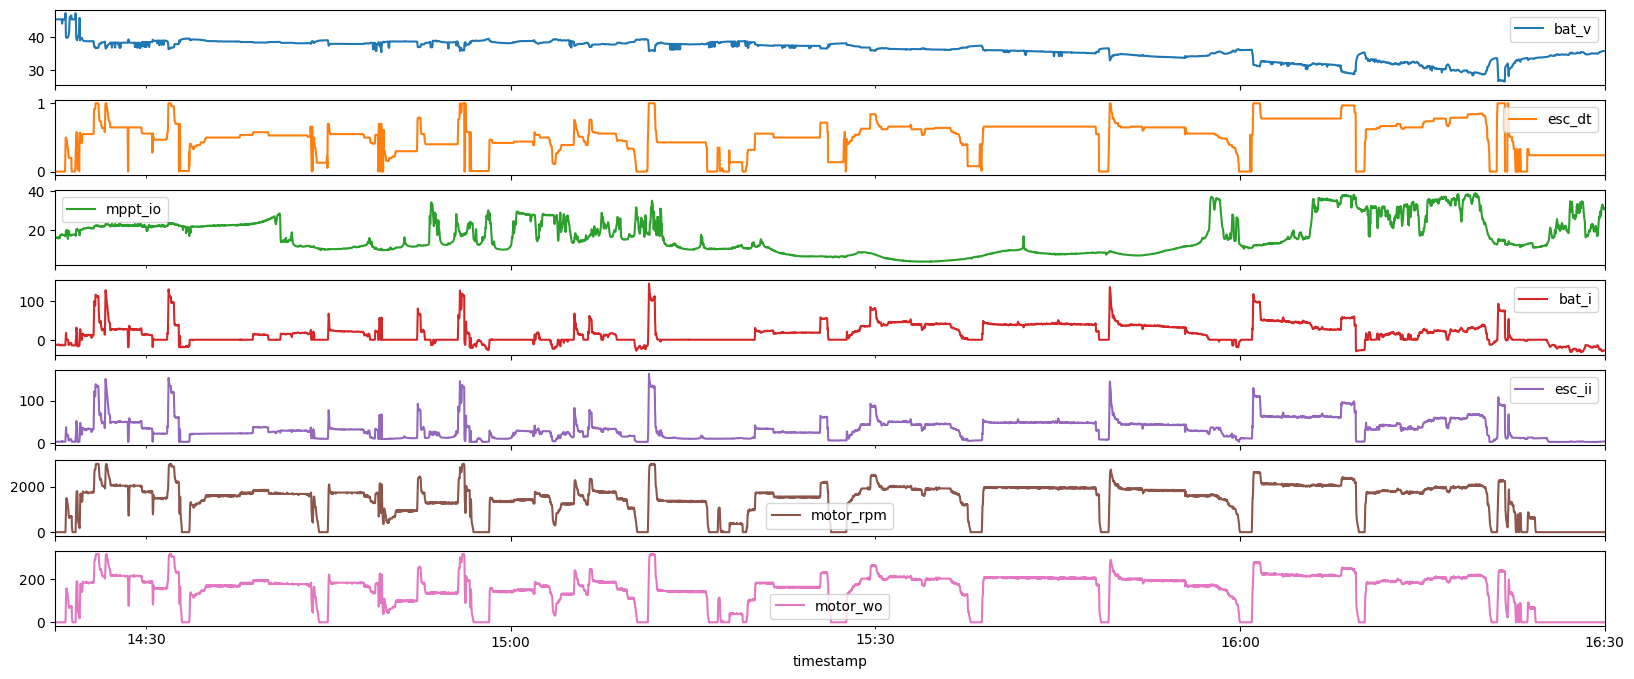

In [2]:
tzinfo = timezone("America/Sao_Paulo")
# start = pd.Timestamp(
#     year=2020, month=1, day=31, hour=12, minute=9, second=0, tzinfo=tzinfo
# ).tz_convert(None)
# end = pd.Timestamp(
#     year=2020, month=1, day=31, hour=12, minute=13, second=0, tzinfo=tzinfo
# ).tz_convert(None)

start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

df = pd.read_csv("../../../models/2020/boat_data_1s.csv")
# df = pd.read_csv("../../../models/2020/boat_data_100ms.csv")
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")

df = df.loc[
    (df.index >= start) & (df.index <= end),
    ["bat_v", "esc_dt", "mppt_io", "bat_i", "esc_ii", "motor_rpm"],
]
df = df.interpolate(method="time")

rpm_to_radps = (2 * np.pi) / 60
df["motor_wo"] = df["motor_rpm"] * rpm_to_radps

df.plot(subplots=True, figsize=(20, 8))
plt.show()


In [3]:
from keras.models import Sequential, save_model, load_model
from keras.layers import (
    Dense,
    GRU,
    LSTM,
    SimpleRNN,
    Dropout,
    Conv1D,
    MaxPooling1D,
    Flatten,
    LeakyReLU,
)
from keras.optimizers import RMSprop, Adagrad
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from keras_visualizer import visualizer
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf


In [4]:
# Select the data

original_data = df[["esc_dt", "bat_v", "esc_ii", "motor_wo"]].to_numpy(dtype=np.float32)
train_data = original_data

# Standarnize the data to have mean of 0 and std deviation of 1
stdscaler = StandardScaler()
train_data = stdscaler.fit_transform(train_data)

# Scale the data to be between 0 and 1
mmscaler = MinMaxScaler()
train_data = mmscaler.fit_transform(train_data)

# Reformat input data into a shape: (n_samples x timesteps x n_features)
reformat_data = []
n_future = 1
n_past = 10

# Separate time (T), input/features (X) and output/targets (Y)
T = (df.index - df.index[0]).to_numpy().astype(
    np.float64
) * 1e-9  # simulation time in seconds
X = train_data[:, :2]
Y = train_data[:, 2:]
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0, shuffle=False
)

# We want to use the current input samples to predict the current output samples,
# so we are setting up the data as a 1-sample sliding window for every sample.
win_lenght = 1
num_features = Y.shape[1]
batch_size = len(X_train)
cfg = dict(length=win_lenght, sampling_rate=1, stride=1, batch_size=batch_size)
train_generator = TimeseriesGenerator(data=X_train, targets=Y_train, **cfg)
test_generator = TimeseriesGenerator(data=X_test, targets=Y_test, **cfg)
print("train shape:", X_train.shape)
print("test  shape:", X_test.shape)
print(
    "train generator shape:", train_generator[0][0].shape, train_generator[0][1].shape
)
print("test generator shape:", test_generator[0][0].shape, test_generator[0][1].shape)


X shape: (7651, 2)
Y shape: (7651, 2)
train shape: (6120, 2)
test  shape: (1531, 2)
train generator shape: (6119, 1, 2) (6119, 2)
test generator shape: (1530, 1, 2) (1530, 2)


In [16]:
# If generators are too slow, we can transform them back to arrays again
train_data = []
train_targets = []

for batch_data, batch_targets in train_generator:
    train_data.extend(batch_data)
    train_targets.extend(batch_targets)

train_data = np.array(train_data)
train_targets = np.array(train_targets)

test_data = []
test_targets = []

for batch_data, batch_targets in test_generator:
    test_data.extend(batch_data)
    test_targets.extend(batch_targets)

test_data = np.array(test_data)
test_targets = np.array(test_targets)


In [29]:
# Check: DOI: 10.1109/AERO50100.2021.9438279

model = Sequential()
model.add(
    SimpleRNN(
        units=5,
        activation="relu",
        input_shape=(win_lenght, num_features),
        return_sequences=True,
        use_bias=False,
    )
)
model.add(
    SimpleRNN(
        units=2,
        activation="relu",
        input_shape=(win_lenght, num_features),
        return_sequences=True,
        use_bias=False,
    )
)
model.add(
    Dense(
        units=2,
        activation="relu",
        input_shape=(win_lenght, num_features),
        use_bias=False,
    ),
)
# model.add(Dropout(rate=0.001))

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 5)              35        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 2)              14        
                                                                 
 dense_5 (Dense)             (None, 1, 2)              4         
                                                                 
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Create an instance of EarlyStopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",  # Metric to monitor for improvement
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the weights of the best model found during training
    mode="min",
)

# Compile the model
model.compile(
    optimizer=RMSprop(learning_rate=0.001), loss="mean_squared_error", run_eagerly=False
)

# Train the model
history = model.fit(
    x=train_generator[0][0],
    y=train_generator[0][1].reshape(train_generator[0][0].shape),
    validation_data=(
        test_generator[0][0],
        test_generator[0][1].reshape(test_generator[0][0].shape),
    ),
    # x=train_data.reshape(train_generator[0][0].shape),
    # y=train_targets.reshape(train_generator[0][0].shape),
    # validation_data=(
    #     test_data.reshape(test_generator[0][0].shape),
    #     test_targets.reshape(test_generator[0][0].shape),
    # ),
    epochs=1000,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping],
    workers=16,
    shuffle=False,
)

save_model(model, f"./keras_models/{model.name}.keras")


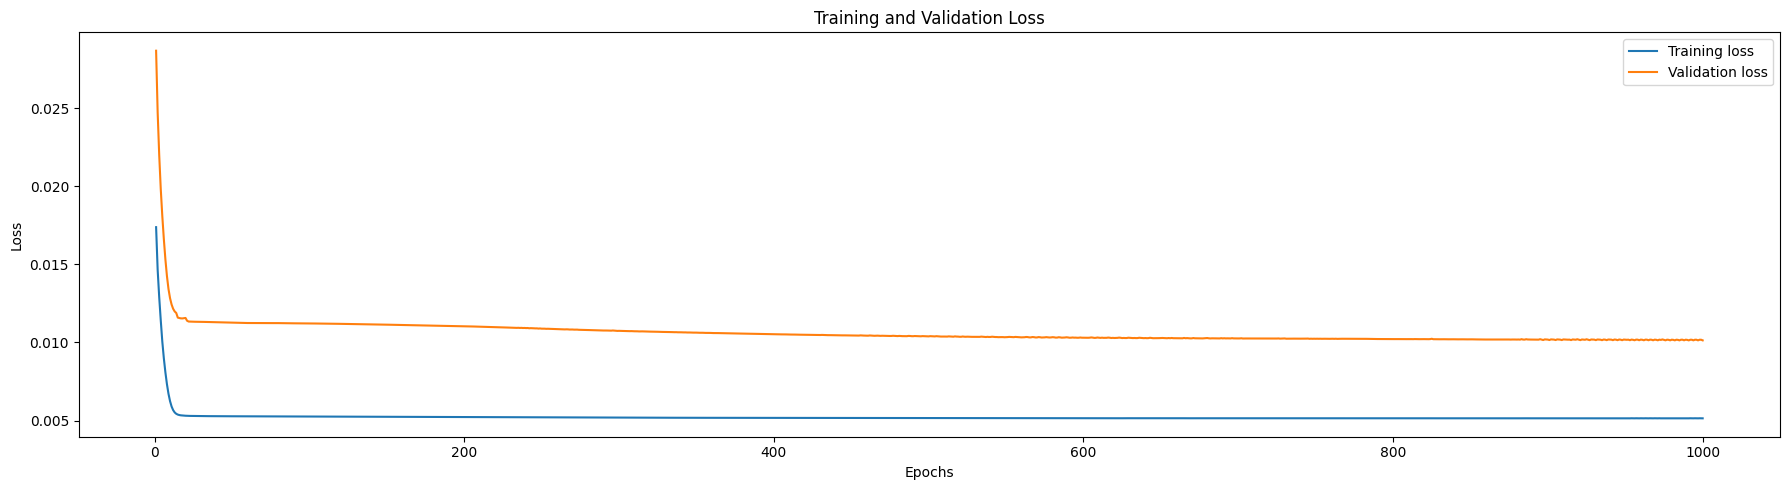

In [40]:
# Plot training and validation loss
epochs = range(1, len(history.history["loss"]) + 1)
plt.figure(figsize=(18, 5))
plt.plot(epochs, history.history["loss"], label="Training loss")
plt.plot(epochs, history.history["val_loss"], label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
# use the test data to predict the model response
Y_pred_test = model.predict(test_generator)
Y_pred_test = Y_pred_test.reshape(Y_pred_test.shape[0], Y_pred_test.shape[2])

Y_pred_train = model.predict(train_generator)
Y_pred_train = Y_pred_train.reshape(Y_pred_train.shape[0], Y_pred_train.shape[2])


In [37]:
# Rescale back
data_out_test = np.hstack(
    [np.zeros((X_test.shape[0] - 1, X_test.shape[1])), Y_pred_test]
)
data_out_test = mmscaler.inverse_transform(data_out_test)
data_out_test = stdscaler.inverse_transform(data_out_test)
data_out_test = data_out_test[:, 2:]

data_out_train = np.hstack(
    [np.zeros((X_train.shape[0] - 1, X_train.shape[1])), Y_pred_train]
)
data_out_train = mmscaler.inverse_transform(data_out_train)
data_out_train = stdscaler.inverse_transform(data_out_train)
data_out_train = data_out_train[:, 2:]


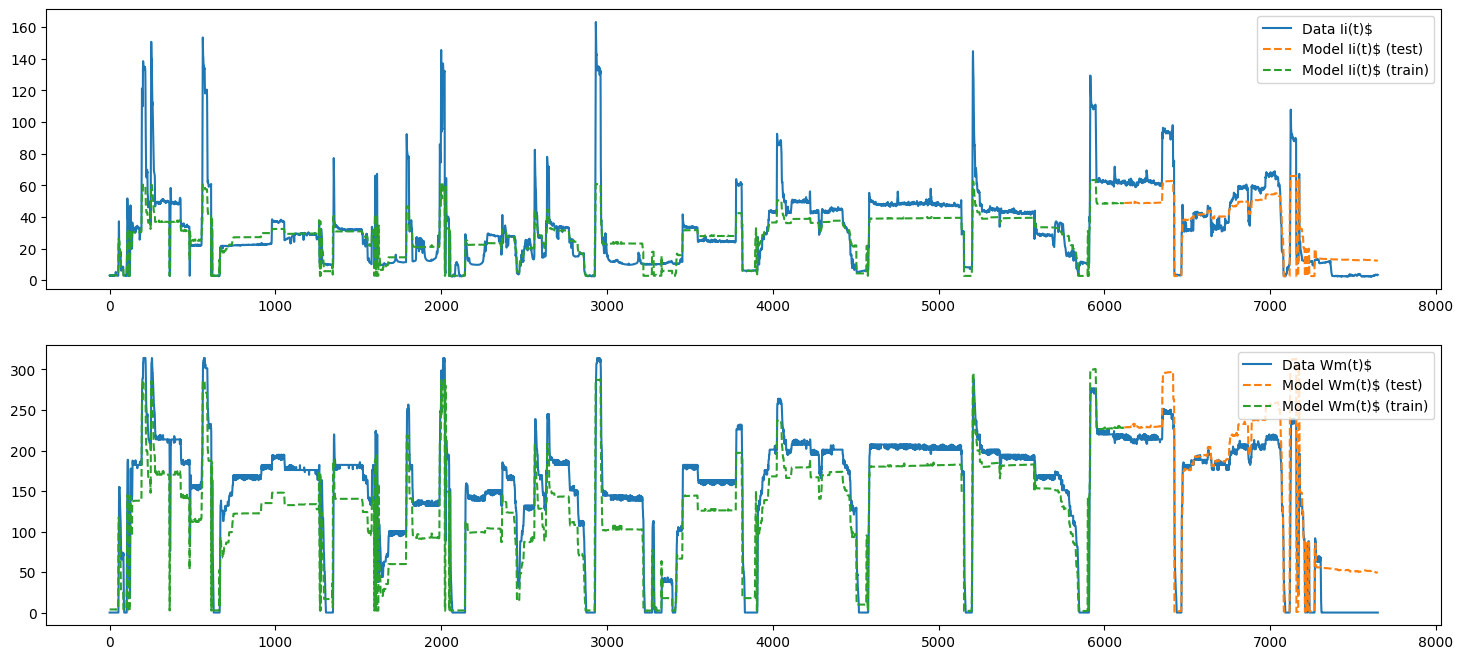

In [39]:
fig, ax = plt.subplots(2, figsize=(18, 8))

ax[0].plot(T[: len(original_data)], original_data[:, 2], label=f"Data Ii(t)$")
ax[0].plot(
    T[(len(original_data) - len(data_out_test)) :],
    data_out_test[:, 0],
    "--",
    label=f"Model Ii(t)$ (test)",
)
ax[0].plot(
    T[: len(data_out_train)],
    data_out_train[:, 0],
    "--",
    label=f"Model Ii(t)$ (train)",
)
ax[0].legend(loc=1)

ax[1].plot(T[: len(original_data)], original_data[:, 3], label=f"Data Wm(t)$")
ax[1].plot(
    T[(len(original_data) - len(data_out_test)) :],
    data_out_test[:, 1],
    "--",
    label=f"Model Wm(t)$ (test)",
)
ax[1].plot(
    T[: len(data_out_train)],
    data_out_train[:, 1],
    "--",
    label=f"Model Wm(t)$ (train)",
)
ax[1].legend(loc=1)

plt.show()
